<a href="https://colab.research.google.com/github/smalaboy/EEG-epileptic-spikes-detection/blob/main/Experimentation%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting up Spark environment

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Reading dataset from files

In [ ]:
positive_series = np.fromfile('/content/drive/MyDrive/datasets/exp1-train-400pos.bin', dtype=np.float32).reshape([400, 5, 768])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
negative_series = np.fromfile('/content/drive/MyDrive/datasets/exp1-train-2000neg.bin', dtype=np.float32).reshape([2000, 5, 768])

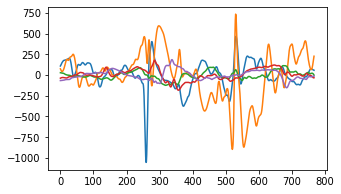

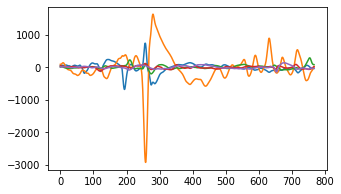

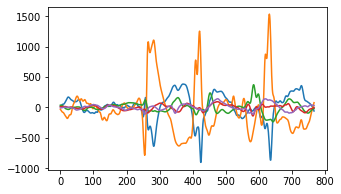

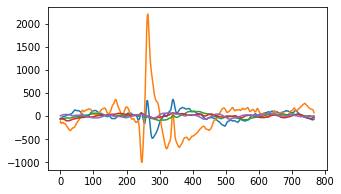

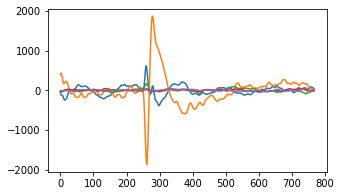

In [ ]:
# Dispplay an example of a positive spike time series
for k in range(5):
  j = int(random.randint(0, 400)) # 0 to 399
  j = k
  # if j != 6:
  #   continue
  plt.figure(k, figsize=(5, 3))
  for i in range(5):
    plt.plot(positive_series[j,i])

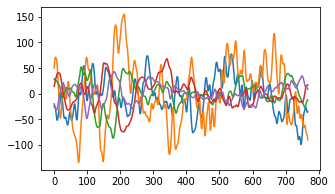

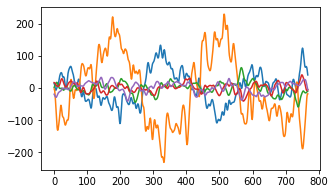

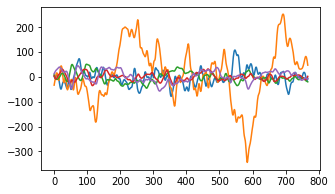

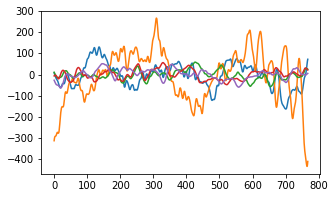

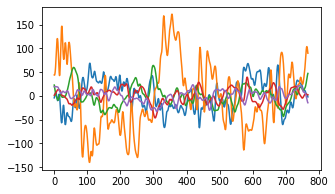

In [ ]:
# Displays an example of a negative spike time series
for k in range(5):
  j = int(random.randint(0, 200)) # 0 to 399
  plt.figure(k, figsize=(5, 3))
  for i in range(5):
    plt.plot(negative_series[j,i])

In [ ]:
positive_series_rdd = spark.sparkContext.parallelize(positive_series)
negative_series_rdd = spark.sparkContext.parallelize(negative_series)
positive_training_series_rdd = spark.sparkContext.parallelize(positive_series[:350])
positive_testing_series_rdd = spark.sparkContext.parallelize(positive_series[350:])
negative_training_series_rdd = spark.sparkContext.parallelize(negative_series[:1750])
negative_testing_series_rdd = spark.sparkContext.parallelize(negative_series[1750:])

In [ ]:
# positive_series_rdd.first()

Compute features

In [ ]:
import itertools
import pywt

def extract_features(series):
  mean_1 = np.mean(series[0])
  mean_2 = np.mean(series[1])
  mean_3 = np.mean(series[2])
  mean_4 = np.mean(series[3])
  mean_5 = np.mean(series[4])

  max_1 = np.max(series[0])
  max_2 = np.max(series[1])
  max_3 = np.max(series[2])
  max_4 = np.max(series[3])
  max_5 = np.max(series[4])

  min_1 = np.min(series[0])
  min_2 = np.min(series[1])
  min_3 = np.min(series[2])
  min_4 = np.min(series[3])
  min_5 = np.min(series[4])

  sd_1 = np.std(series[0])
  sd_2 = np.std(series[1])
  sd_3 = np.std(series[2])
  sd_4 = np.std(series[3])
  sd_5 = np.std(series[4])

  # return list(map(float, itertools.chain(*series)))
  return list(map(float, ( max_1, max_2, max_3, max_4, max_5, mean_1, mean_2, mean_3, mean_4, mean_5, min_1, min_2, min_3, min_4, min_5, sd_1, sd_2, sd_3, sd_4, sd_5)))

In [ ]:
positive_rdd = positive_series_rdd.map(lambda x: (extract_features(x), 1.0))
negative_rdd = negative_series_rdd.map(lambda x: (extract_features(x), 0.0))
positive_training_rdd = positive_training_series_rdd.map(lambda x: (extract_features(x), 1.0))
negative_training_rdd = negative_training_series_rdd.map(lambda x: (extract_features(x), 0.0))
positive_testing_rdd = positive_testing_series_rdd.map(lambda x: (extract_features(x), 1.0))
negative_testing_rdd = negative_testing_series_rdd.map(lambda x: (extract_features(x), 0.0))

Building the Dataframe

In [ ]:
from pyspark.sql.types import StructType, ArrayType, FloatType, StringType
dataSchema = StructType()\
  .add("metrics", ArrayType(FloatType()))\
  .add("label", FloatType())

In [ ]:
from pyspark.sql.dataframe import DataFrame
positive_df = spark.createDataFrame(positive_rdd, schema=dataSchema)
negative_df = spark.createDataFrame(negative_rdd, schema=dataSchema)
full_df = positive_df.union(negative_df)

positive_training_df = spark.createDataFrame(positive_training_rdd, schema=dataSchema)
negative_training_df = spark.createDataFrame(negative_training_rdd, schema=dataSchema)
full_training_df = positive_training_df.union(negative_training_df)

positive_testing_df = spark.createDataFrame(positive_testing_rdd, schema=dataSchema)
negative_testing_df = spark.createDataFrame(negative_testing_rdd, schema=dataSchema)
full_testing_df = positive_testing_df.union(negative_testing_df)

In [ ]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
arrayToVectorUdf = udf(lambda vs: Vectors.dense(vs), VectorUDT())

In [ ]:
full_df = full_df.withColumn("features", arrayToVectorUdf(full_df.metrics))
full_training_df = full_training_df.withColumn("features", arrayToVectorUdf(full_training_df.metrics))
full_testing_df = full_testing_df.withColumn("features", arrayToVectorUdf(full_testing_df.metrics))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_true, y_pred, labels=[], classes=[]):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    matrix = confusion_matrix(y_true, y_pred, labels=labels)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure()

    cmap=plt.cm.Greens

    print(matrix)

    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # fmt = '.2f'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.savefig("confusion_matrix.png")
    plt.show()

**Using LogisticRegression classifier**

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label")
lrModel = lr.fit(full_training_df)

In [ ]:
predictions = lrModel.transform(full_testing_df)

In [ ]:
predictions.show(10)

+--------------------+-----+--------------------+--------------------+--------------------+----------+
|             metrics|label|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+----------+
|[377.52173, 1233....|  1.0|[377.521728515625...|[-2.7569915660643...|[0.05969300510954...|       1.0|
|[310.42355, 2491....|  1.0|[310.423553466796...|[-7.9206723401977...|[3.63026242708240...|       1.0|
|[347.81857, 1519....|  1.0|[347.818572998046...|[-3.6046060063175...|[0.02647800560890...|       1.0|
|[267.9723, 1834.1...|  1.0|[267.972290039062...|[-4.3355444096595...|[0.01292548729026...|       1.0|
|[281.5679, 1689.2...|  1.0|[281.567901611328...|[-3.7526726108343...|[0.02291744780272...|       1.0|
|[272.6679, 1458.5...|  1.0|[272.667907714843...|[-2.3043979668084...|[0.09075937769974...|       1.0|
|[171.07172, 558.7...|  1.0|[171.071716308593...|[0.34927236738890...|[0.

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
lrEvaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
lrEvaluator.evaluate(predictions)

0.9759496087039511

[[1.   0.  ]
 [0.14 0.86]]


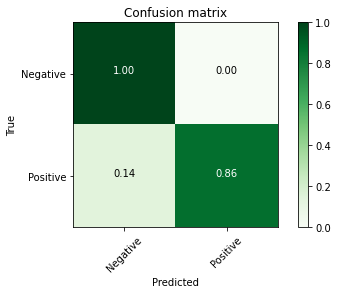

In [ ]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
show_confusion_matrix(y_true, y_pred, labels=[0.0, 1.0], classes=['Negative', "Positive"])

**Decision tree classifier**

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

dtModel = dt.fit(full_training_df)

In [ ]:
dtPredictions = dtModel.transform(full_testing_df)
dtPredictions.show(10)

+--------------------+-----+--------------------+-------------+--------------------+----------+
|             metrics|label|            features|rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+-------------+--------------------+----------+
|[377.52173, 1233....|  1.0|[377.521728515625...|   [1.0,40.0]|[0.02439024390243...|       1.0|
|[310.42355, 2491....|  1.0|[310.423553466796...|  [1.0,185.0]|[0.00537634408602...|       1.0|
|[347.81857, 1519....|  1.0|[347.818572998046...|  [1.0,185.0]|[0.00537634408602...|       1.0|
|[267.9723, 1834.1...|  1.0|[267.972290039062...|  [1.0,185.0]|[0.00537634408602...|       1.0|
|[281.5679, 1689.2...|  1.0|[281.567901611328...|  [1.0,185.0]|[0.00537634408602...|       1.0|
|[272.6679, 1458.5...|  1.0|[272.667907714843...|   [1.0,40.0]|[0.02439024390243...|       1.0|
|[171.07172, 558.7...|  1.0|[171.071716308593...|    [0.0,5.0]|           [0.0,1.0]|       1.0|
|[866.9099, 1376.3...|  1.0|[866.9099121

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
dtEvaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
dtEvaluator.evaluate(dtPredictions)

0.9666666666666667

[[0.98 0.02]
 [0.1  0.9 ]]


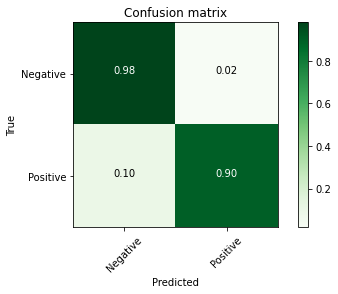

In [ ]:
y_true = dtPredictions.select(['label']).collect()
y_pred = dtPredictions.select(['prediction']).collect()
show_confusion_matrix(y_true, y_pred, labels=[0.0, 1.0], classes=['Negative', "Positive"])

**Random forestclassifier**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

rfModel = rf.fit(full_training_df)

In [ ]:
rfPredictions = rfModel.transform(full_testing_df)
rfPredictions.show(10)

+--------------------+-----+--------------------+--------------------+--------------------+----------+
|             metrics|label|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+----------+
|[377.52173, 1233....|  1.0|[377.521728515625...|[4.24743593438719...|[0.21237179671935...|       1.0|
|[310.42355, 2491....|  1.0|[310.423553466796...|[0.74581601764182...|[0.03729080088209...|       1.0|
|[347.81857, 1519....|  1.0|[347.818572998046...|[0.67090848335572...|[0.03354542416778...|       1.0|
|[267.9723, 1834.1...|  1.0|[267.972290039062...|[0.53613859828699...|[0.02680692991434...|       1.0|
|[281.5679, 1689.2...|  1.0|[281.567901611328...|[0.64733116915698...|[0.03236655845784...|       1.0|
|[272.6679, 1458.5...|  1.0|[272.667907714843...|[1.67272636040666...|[0.08363631802033...|       1.0|
|[171.07172, 558.7...|  1.0|[171.071716308593...|[13.9849506868953...|[0.

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
rfEvaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
rfEvaluator.evaluate(rfPredictions)

0.9759496087039511

[[1.   0.  ]
 [0.14 0.86]]


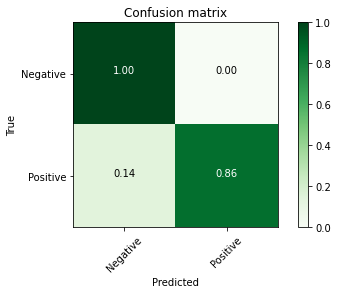

In [ ]:
y_true = rfPredictions.select(['label']).collect()
y_pred = rfPredictions.select(['prediction']).collect()
show_confusion_matrix(y_true, y_pred, labels=[0.0, 1.0], classes=['Negative', "Positive"])

**SVM**

In [ ]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(featuresCol="features", labelCol="label")

lsvcModel = lsvc.fit(full_training_df)

In [ ]:
lsvcPredictions = lsvcModel.transform(full_testing_df)
lsvcPredictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|             metrics|label|            features|       rawPrediction|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[377.52173, 1233....|  1.0|[377.521728515625...|[-1.4133823500978...|       1.0|
|[310.42355, 2491....|  1.0|[310.423553466796...|[-4.3332183421222...|       1.0|
|[347.81857, 1519....|  1.0|[347.818572998046...|[-2.0690883115322...|       1.0|
|[267.9723, 1834.1...|  1.0|[267.972290039062...|[-2.8145411957717...|       1.0|
|[281.5679, 1689.2...|  1.0|[281.567901611328...|[-2.6232204413718...|       1.0|
|[272.6679, 1458.5...|  1.0|[272.667907714843...|[-1.5178535946197...|       1.0|
|[171.07172, 558.7...|  1.0|[171.071716308593...|[0.20288604169187...|       0.0|
|[866.9099, 1376.3...|  1.0|[866.909912109375...|[-3.0267664163170...|       1.0|
|[227.90907, 1283....|  1.0|[227.909072875976...|[-1.0772397299671...|       1.0|
|[469.44717, 133

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
lsvcEvaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
lsvcEvaluator.evaluate(lsvcPredictions)

0.9726403722703445

[[0.996 0.004]
 [0.14  0.86 ]]


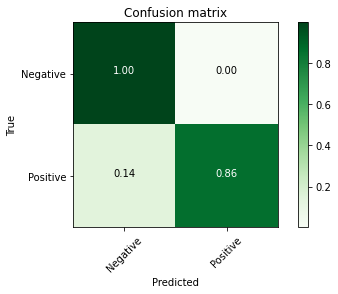

In [ ]:
y_true = lsvcPredictions.select(['label']).collect()
y_pred = lsvcPredictions.select(['prediction']).collect()
show_confusion_matrix(y_true, y_pred, labels=[0.0, 1.0], classes=['Negative', "Positive"])

**Testing data**

In [ ]:
test_series = np.fromfile('/content/drive/MyDrive/datasets/exp12-test-1200.bin', dtype=np.float32).reshape([1200, 5, 768])
test_rdd_ = spark.sparkContext.parallelize(test_series)

In [ ]:
test_rdd = test_rdd_.map(lambda x: (extract_features(x), None))

In [ ]:
test_df = spark.createDataFrame(test_rdd, schema=dataSchema)
test_df = test_df.withColumn("features", arrayToVectorUdf(test_df.metrics))

In [ ]:
test_df.head(5)

[Row(metrics=[-84.48851776123047, -76.99972534179688, -70.13329315185547, -64.37525177001953, -60.07806396484375, -57.322628021240234, -55.89006805419922, -55.254859924316406, -54.7889289855957, -53.944942474365234, -52.59593963623047, -51.11629104614258, -50.00609588623047, -49.84101104736328, -51.1290283203125, -53.782691955566406, -57.1125602722168, -60.18331527709961, -62.12675476074219, -62.535064697265625, -61.595420837402344, -60.006229400634766, -58.50824737548828, -57.33441925048828, -55.973209381103516, -53.35798645019531, -48.596378326416016, -41.702728271484375, -33.515777587890625, -24.938106536865234, -16.272653579711914, -7.251334190368652, 2.2375071048736572, 11.81909465789795, 20.57038688659668, 27.272584915161133, 30.798709869384766, 30.674175262451172, 27.416608810424805, 22.6273136138916, 18.095186233520508, 15.067657470703125, 14.19323444366455, 15.573214530944824, 18.63608741760254, 22.41537857055664, 25.96500015258789, 28.38125228881836, 28.867279052734375, 27.03

In [ ]:
# test_predictions = lrModel.transform(test_df)
# test_predictions = dtModel.transform(test_df)
# test_predictions = rfModel.transform(test_df)
test_predictions = lsvcModel.transform(test_df)
# test_predictions = mlpModel.transform(test_df)

In [ ]:
test_predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|             metrics|label|            features|       rawPrediction|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-84.48852, -76.9...| null|[-84.488517761230...|[-6.0814780762438...|       1.0|
|[27.256372, 24.11...| null|[27.2563724517822...|[3.22659374386227...|       0.0|
|[-39.467644, -29....| null|[-39.467643737792...|[3.84482785703684...|       0.0|
|[-51.355503, -63....| null|[-51.355503082275...|[1.34608561088874...|       0.0|
|[1.9953729, 5.143...| null|[1.99537289142608...|[3.32913979979963...|       0.0|
|[-13.719555, -14....| null|[-13.719554901123...|[-0.2700756942600...|       1.0|
|[-11.395216, -6.8...| null|[-11.395215988159...|[2.78319025001501...|       0.0|
|[16.082405, 22.17...| null|[16.0824050903320...|[2.22063506912278...|       0.0|
|[20.376247, 18.62...| null|[20.3762474060058...|[3.68225755794987...|       0.0|
|[-22.286037, -2

In [ ]:
test_predictions.groupBy(test_predictions.prediction).count().collect()

[Row(prediction=0.0, count=1102), Row(prediction=1.0, count=98)]

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id, udf, row_number
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

# r = test_predictions.select("prediction").withColumn("id", monotonically_increasing_id())\
#   .withColumn("outcome", test_predictions.prediction.cast(IntegerType()))
w = Window.orderBy(monotonically_increasing_id())
r = test_predictions.select("prediction").withColumn("id", row_number().over(w)-1)\
  .withColumn("outcome", test_predictions.prediction.cast(IntegerType()))

In [ ]:
final_r = r.select("outcome", "id")

In [ ]:
# final_r.head(1200)

In [ ]:
# final_r.write.csv("submission3.csv", header=True)

In [ ]:
final_r.toPandas().to_csv('submission.csv', index=False)